In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

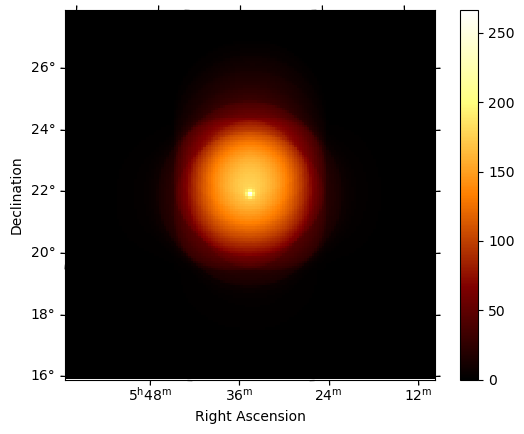

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
shift = +0.085
tilt = 1e-24 #0.015

N = 831 #47
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True

In [5]:
%%time
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = 1e-24 #energy independent, else: #np.random.normal(0, tilt, 1)
        #print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        #print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass

0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8073866804278977 1.4869505805460803
norm 1.198650965923269 0.5313143578579923
norm 1.1160681154941186 0.24874226137893563
norm 0.7619094016142062 0.20081619176248522
norm 0.9697970672021495 0.2039734174837876
norm 1.2706766106301062 0.224770093226466
norm 0.825776096070646 0.24047569071032981
norm 0.9398065783401045 0.3022016800106569
norm 1.0552953916654864 0.3901467151686679
norm 0.8804411390824128 0.5201756453344705
norm 2.5943593019279243 1.0212836011722835
norm -0.7598814421521984 1.2455891909859322
norm -1.6224369526314086 3.21954708418361
norm -11.241642395698866 5.7580226208272105
norm 29.900649639748583 38.15618194828429
norm -96.30496284445628 84.7941288135253
norm -611.6190959244408 136.25027694021787
norm 3302.291442718216 5604.526107270441
norm 1.0 0
1
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6970751392347045 0.8881095680324468
norm 0.6848774526157648 0.3514995746798099
norm 1.228670540274

norm 7.611921011695276 13.887427152500411
norm -54.138543940559174 13.458081285479127
norm -869.6800375183394 361.8393882182399
norm -4545.253711088836 2399.0166406686913
norm 1.0 0
10
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5149843484637244 0.9054595969996181
norm 1.0105548416889047 0.3790904235565713
norm 0.628943080619888 0.19240359147283806
norm 1.314036021605822 0.19754036518229026
norm 1.0255416677378066 0.20583896014804265
norm 1.126755672091041 0.2325926826215094
norm 0.8002546076077334 0.2497398115467052
norm 0.6834781126929261 0.2863367167807649
norm 1.6015142487039742 0.3870099257250101
norm 1.121146815948805 0.4405160307824592
norm 0.8420371215201906 0.4963805338442162
norm 0.037532449955589624 0.5014047550387974
norm 1.0758946905447249 0.7400339646811072
norm 1.1225000677682737 0.9105392971860783
norm 0.5347915286408109 1.0168743526547044
norm 1.6307947293788754 1.388411705832135
norm 2.2371753639017147 2.1918983188905194
norm 0.4651070477060381 1.723

norm 0.8474239977472963 0.380448637645274
norm 0.6568665988073366 0.5467125740683881
norm 0.30146798466851543 0.7491836696897218
norm 3.625123675369388 1.975608519718332
norm -1.5509741791889589 2.927746241757149
norm 3.5102077184548315 9.725188775721422
norm -8.3219346331057 33.215640731638786
norm -140.10951622197706 71.96632807416637
norm 420.59695806929324 806.1929377465807
norm 1.0 0
20
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0832511528751394 1.0920673646691799
norm 0.7531692126471935 0.4359627532922768
norm 1.0746880451514544 0.2294359157583704
norm 0.9245821783791527 0.20311995038274733
norm 0.9802106798328944 0.21481970719828036
norm 1.1833994911814476 0.23680014290266646
norm 0.9814200447893315 0.2521125468729628
norm 1.056058298804074 0.29767080597779777
norm 0.754987088920824 0.32387385977561756
norm 0.9624225226545444 0.40718100959499476
norm 0.8465674797429522 0.461325240812392
norm 1.1874760158899318 0.6492569498822635
norm 1.5176923522112604 0.90020

norm 1.3084401215433052 0.2083772520314164
norm 0.9511275301032512 0.2095982194203184
norm 1.2218170959556136 0.24811287291792578
norm 0.8414456840869542 0.26409457046155743
norm 0.6455170951217536 0.2950884375476189
norm 0.37033538242900266 0.3443772197021936
norm 1.6335298987414535 0.5837421330707826
norm 1.5670302763176154 0.8418322092144649
norm 1.8783702531204933 1.2665744783981248
norm 0.003010646732237471 1.4968267828509654
norm 1.4018420002326875 3.734495654411023
norm 5.329451648475804 9.498550194662881
norm -73.66308563294518 58.0438064674295
norm -628.2378067003392 723.7996863181878
norm 1.0 0
30
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.633332607843104 1.2169886116747213
norm 0.9400098782997888 0.4359197441677597
norm 1.1896515132982857 0.2293249500787867
norm 0.9860451268542835 0.1939261563844185
norm 1.010856272015734 0.19916181545722791
norm 0.5887960506332486 0.2003309342387662
norm 0.7669984154202836 0.23543229562073598
norm 1.6868365201907904 0.304

39
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.745525712737283 1.2115214947443294
norm 1.0375434323276764 0.4847899035875452
norm 0.7109886863457762 0.2408265063496616
norm 1.1386866593378517 0.2235008711832173
norm 1.11344578869679 0.22925889699181687
norm 0.8683790594528694 0.23436310362020485
norm 1.230778943747461 0.2720602948436974
norm 1.0132965433207832 0.2969091012221754
norm 0.9522006218469519 0.3282416425386227
norm 1.0294300301879455 0.38812056007568646
norm 0.6292452639055844 0.42466562662772817
norm 1.4402990710917751 0.6177736408651291
norm 0.5005677016677867 0.6851606919116074
norm 0.14184823129782673 0.8256955522686767
norm 1.3836084626297283 1.4166750541002724
norm 2.1371864709838815 2.5554045048748244
norm -0.07322587595627314 3.3719770314804287
norm 11.341473778443545 10.793101194244938
norm 1.0 0
40
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.32416288915883 1.221090472564165
norm 0.7402785934999058 0.4241326381292584
norm 1.167451

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9284046286021428 0.8135460538053735
norm 0.5388063393130309 0.3202477142348537
norm 1.0938467168726251 0.20364632095470242
norm 0.9763767438290245 0.19621460148208622
norm 0.8896653444951464 0.22140148879229987
norm 0.9092554018123548 0.25726055026110844
norm 1.3975549628408392 0.33804102748115633
norm 1.12763832625796 0.40266086208978663
norm 1.2025281919016728 0.4970058939089744
norm 1.3054313109710871 0.6069236780333659
norm 1.1059288932288187 0.7581957942923575
norm -0.2922265481029008 0.7916333975169763
norm -0.1990146391391695 0.8677233715169621
norm 0.5682364683218866 1.1947563375316803
norm 0.06650284775718396 1.1844260157023536
norm 2.305928112450736 2.027372009870863
norm 0.7930839738926853 1.3626937186985661
norm 1.8485439511973207 1.9353887399883958
norm 1.0 0
42
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.1288416374315595 2.6744485384429195
norm 1.0599071458574658 0.7430283732064494
norm 1.2460

norm 0.8508587309928961 1.5196222006340712
norm -2.4033281940733495 2.09154674960341
norm 1.1493652964984042 6.23668495026644
norm -0.0750462404849841 16.469353415780947
norm 32.11946706825766 77.53432690879137
norm 1.0 0
51
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.853978822007303 1.1575793314949263
norm 0.7239691208670288 0.4199229081900299
norm 1.0216485717028894 0.2380159168768193
norm 0.7807375764261717 0.21275451117049307
norm 1.0387511492516213 0.23740451615542665
norm 1.505868662886873 0.27449795067814803
norm 0.6421971785931196 0.2846519566868911
norm 1.0489069642587572 0.35379267638889705
norm 1.3295192067724828 0.41684928923133646
norm 0.9656249659682608 0.4780668123254104
norm 1.141034478078279 0.5832847014335111
norm 0.6059803851697797 0.614138099224049
norm 0.0382101416007857 0.651629068792676
norm 0.33119922871264434 0.8883756161308917
norm 0.016538435270516877 0.8791248791375111
norm 2.6539709061698473 1.9327114423340401
norm 3.4048069894403374 2.218

norm 1.6769661210669233 0.4109763482327031
norm 0.46191766099582376 0.45877706063214413
norm 1.0447857733011172 0.8177779834824455
norm -0.7570412718516016 1.3383724984929701
norm 4.931232158504043 4.027575872106871
norm 5.181545043352888 11.155682299959619
norm -56.95583012318584 15.285493807151362
norm -168.24816897152 67.36951535155403
norm -611.8617761007512 1653.8321873431933
norm 3134.1366138682247 5485.78164257678
norm 1.0 0
61
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3134627041198124 1.2892547454100887
norm 0.6208230268447045 0.48636294940775515
norm 1.2590844216419752 0.23945543530817184
norm 0.7930051023224338 0.18520936989901762
norm 1.282372537791594 0.19292097349605244
norm 0.9078349941003372 0.18916058842523048
norm 0.8324337634734745 0.21007257008109015
norm 1.0258394520495908 0.2620664017158862
norm 1.0626907466605777 0.33931837788913255
norm 1.0925257911083663 0.485855334698765
norm 0.771116891781836 0.8127716397630188
norm 1.6667463787059946 1.78

norm 0.9803422150108663 0.1766930478736423
norm 0.7099888728103776 0.183803361583669
norm 1.0643039340708853 0.21782114823826917
norm 0.7535389416324959 0.24021991783317387
norm 1.3392700237532362 0.3142554674365581
norm 1.57343150260693 0.3990994133019904
norm 1.083797994068812 0.4869346845135973
norm 0.7252266910300575 0.6197857602117982
norm -0.5620159288728994 0.6832823430906821
norm 1.2229969175187123 1.556458433623237
norm 5.128278494382309 3.2528346768286642
norm -4.6352690886131525 3.743001300157531
norm -4.422716125417364 8.075204959923191
norm 6.100920087962023 42.631098243642185
norm 77.10029925956272 161.80933537050356
norm 1.0 0
71
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.30843232885227484 1.2260312319645743
norm 1.383327164905999 0.5107000991940639
norm 1.126385629359552 0.25450454436093356
norm 1.0484974744731883 0.2170900949428847
norm 0.9533921221324458 0.21772883927973138
norm 0.6432874081109845 0.21323621121770409
norm 1.114789476180904 0.251051

norm 904.9421905851608 2651.699012749632
norm 1.0 0
80
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4279364452348813 1.1734937980768028
norm 1.2842537435471222 0.5028904488638197
norm 1.2890784844163912 0.26018688127343426
norm 0.5306812766271042 0.20274634242121933
norm 0.8783543100540837 0.21615949408021204
norm 1.1315642682822091 0.2340968500499792
norm 1.4105048961745978 0.26606347396181984
norm 1.0106929237274977 0.277873390010619
norm 1.47441524436843 0.34826209612334147
norm 0.26094613910838876 0.3127222689587098
norm 0.984621226942898 0.4489250335413682
norm 0.2900336295290379 0.45976295654528687
norm 0.5861904248902604 0.6242232524913454
norm 2.736723217605016 1.1662916173905173
norm 0.29471841746717403 0.9399247903868787
norm 4.2035201712092265 2.82421317442073
norm 1.1290311165825697 2.6530422589441547
norm -4.499990247481883 2.6453035325559395
norm 1.0 0
81
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.9760869474920412 1.5031790317846823
no

norm 0.5185406475192337 1.7443599088797395
norm 0.9337114012953145 3.183296428584739
norm -3.8823467887812635 6.520692156890774
norm 19.798673334140716 23.990007946271433
norm 77.45034193517215 104.11582939803799
norm 81.44658914612683 287.7010765384712
norm 1.0 0
90
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.355387748691245 1.5713302406201284
norm 1.6057284496799569 0.638634346284006
norm 0.7610855934595887 0.2894473421850112
norm 0.8461916008188395 0.25568484792062685
norm 1.3938542172642745 0.26768804745455105
norm 0.8713762784037765 0.2642442876666172
norm 0.9764065501456686 0.27903401886863266
norm 0.88473131064789 0.30754690734778545
norm 1.0271296560032441 0.3287231053489992
norm 1.318154986286914 0.4180273976036278
norm 0.3937707315556486 0.39226169382432274
norm 1.9926368101373453 0.6210139868580841
norm 0.5992620508707872 0.599870299876446
norm -0.6267773055634756 0.4767533748102728
norm 2.367448267089329 1.4559250109611004
norm 1.2868093222476327 1.6234633

norm 0.798795020357493 0.27447227259969476
norm 1.2555069212512981 0.35879466698403867
norm 0.9198541223937865 0.4330368201513395
norm 0.3487106678998724 0.5032264538705747
norm 0.6983262545028787 0.7623312251328652
norm 1.6208039042505888 1.2371088998806261
norm 1.77885513268199 2.1166337246478784
norm 1.782779272404802 3.4618648596231845
norm 0.48268351755974015 6.247848675433983
norm 15.040954649714953 22.115522514380547
norm -38.011108318727466 18.096218754059798
norm 1.0 0
100
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.48128712123099004 0.990606144498148
norm 1.4366381992704236 0.416929383255036
norm 0.8923286860807539 0.20120339407644006
norm 1.1000019400192191 0.18566683277050725
norm 0.8411077022787841 0.18619455282620262
norm 1.0425491966415597 0.21752302542514818
norm 1.1892989180637814 0.2598493473428807
norm 0.565352170330923 0.29982074027497463
norm 1.0522703938609101 0.41982740909827065
norm 2.057840911487645 0.7013911885356934
norm 0.9230718936534754 0

norm 0.521428977400501 0.17265286500593097
norm 1.0580488780193935 0.17918103343861852
norm 0.8857882902558852 0.19417444357477084
norm 1.2472673764696431 0.23460806544111112
norm 1.3476671895960428 0.29871276209217157
norm 0.7998301225517945 0.33956134467184235
norm 1.0895917154093269 0.4224318625622072
norm 0.5544105239852147 0.4944539444788803
norm 0.055053121884759915 0.5851244860288976
norm 1.6629419506556653 0.9713386637031802
norm 2.3882362907553336 1.3579391872464313
norm 0.6316312385769989 1.6605409055070546
norm 1.0650492073935314 2.3954521543597673
norm 2.9399017870001853 3.8318515460303417
norm -0.338069496545572 4.528571488849581
norm -220.17254814231882 66.61260750221666
norm 1.0 0
110
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0350252946052028 1.0522801245027642
norm 0.7871327405785898 0.39056971642339583
norm 0.8815195331695516 0.20785267820023876
norm 1.2309185768679436 0.19623204391132196
norm 0.9236448630783679 0.19514691658905198
norm 0.8951169497

norm -93.95251906444331 265.77636581539207
norm -275.2429196364792 113.49814820043763
norm 1.0 0
119
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3268921736760866 0.9332534984481733
norm 0.5420091738602089 0.3542160257655268
norm 1.1703547926041884 0.21945667516113845
norm 1.1526719818691673 0.20300099448400935
norm 0.7905242965859957 0.20682061988324657
norm 0.9440388606438722 0.245996339136564
norm 0.9147420134865003 0.28233787577226294
norm 1.015108747883488 0.34700440738235944
norm 1.3151860576724803 0.4257949456028941
norm 1.0867784344656355 0.5123217771921167
norm 0.7748014755277068 0.6044977055679635
norm 0.43501293770232125 0.7970948144256473
norm 2.1668557367262733 1.2977140318147147
norm -0.17440773262006806 1.2744770193391755
norm 3.1861976126829807 3.0701212637639332
norm -0.8375881948397748 2.69025879488816
norm 4.933323485454457 6.511560362212583
norm -104.04813220822223 111.89297862356938
norm 1.0 0
120
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.

norm 1.166537979646991 1.4261914751299645
norm -1.3981196678873855 2.718244495922832
norm -6.654652516525303 6.407117570665788
norm 78.7578686960131 41.243299026007485
norm -42.07624754763809 83.88283739023741
norm -2385.0080782551427 1136.9062011158828
norm 971.0940906789812 2942.7026223969588
norm 1.0 0
129
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.39551818456256327 0.9707358190609515
norm 0.9049052692932356 0.3944752008783225
norm 1.228223752424717 0.21074164897455389
norm 0.7178959542729283 0.1773911483893578
norm 1.0685982163903383 0.19023769725957232
norm 0.9166220920519267 0.20413605395018913
norm 1.20811839349567 0.24209316581955664
norm 1.4333287783154773 0.30434847595403475
norm 0.6432160834026889 0.3198478980923756
norm 0.41760166620853223 0.4051127388766491
norm 0.8834747869486514 0.6115160886843917
norm 1.175464031225889 0.9480042291636565
norm 2.180841558065632 1.8336553367135209
norm 3.4529234832005415 3.3019559915044656
norm 2.10171766867865 7.237848

norm 0.9522687379369386 0.2279693211827858
norm 1.140441078821586 0.27582023943371753
norm 1.26614172278922 0.319911587635477
norm 0.6862202617374963 0.3706685039634082
norm 1.1709850677357085 0.5100355199754616
norm 1.5972817971058717 0.7300028588075026
norm 0.17229634587835954 0.8176623741008522
norm -0.8631771732349999 1.073265892642517
norm 4.793275165071902 3.413568179231706
norm -2.7781644930279628 4.502034690164924
norm 11.275244532047328 20.435291364389098
norm -226.54256864195423 110.6521027053258
norm 1.0 0
139
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7187842775946545 1.2869820721062677
norm 1.2178500855879142 0.47291782789664283
norm 1.0458583850468828 0.2348430349652418
norm 1.0935671463788665 0.20069060881526402
norm 0.7553677454771565 0.19276071600575406
norm 0.9443529982507681 0.2111315775666298
norm 1.107361730858833 0.23401316265108055
norm 0.9981134964326168 0.2688561374760997
norm 0.9858333382214849 0.32326468061056873
norm 1.5872984864857842 0.4

norm 0.8734780826710546 0.4851900880893607
norm 1.0511451255471982 0.24582942461101046
norm 0.8499299507500921 0.19537737406056616
norm 1.0110542645712723 0.19969885383405692
norm 1.188229885159115 0.21327812434393684
norm 1.158652357385112 0.22423512784896504
norm 0.9228266188498404 0.2502467646451195
norm 0.5705344206047472 0.2649430089230031
norm 1.0475032812133938 0.37698681431214187
norm 0.8909687286614223 0.5135328219894895
norm 2.1141107490966107 0.8953751441066999
norm 0.6780043161211201 1.3349127942894055
norm 0.6105856579889581 2.890739661007972
norm -3.1223282042041154 5.883326559799453
norm -4.6778936038595615 16.43199721003833
norm 23.94918069696383 82.84301895525715
norm 254.2781335157238 497.2246285997309
norm 1.0 0
149
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4851916183359572 0.8834657336790043
norm 1.2867198627957186 0.38555334379110995
norm 1.0828231791029292 0.2002581225764749
norm 1.0879853852046526 0.18095432646547555
norm 0.704096320217233 0.1

norm 9.739783241303131 10.24653457017223
norm 0.6125348405440281 29.274010303804843
norm -87.89068240607632 33.50020522895676
norm 1.0 0
158
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9425936296418507 1.1329610611232621
norm 0.6854081870522608 0.4252445665511647
norm 1.1626430025093277 0.23495583244900956
norm 0.7837716383867055 0.1963185629413043
norm 1.4038208701930408 0.21589579035462023
norm 0.9561194726717033 0.21324731873236077
norm 0.8289188311554394 0.23556681511059588
norm 0.7340589738568475 0.26516928223178926
norm 0.7455058447616291 0.29244734066233613
norm 1.2507191216549216 0.3807565570847037
norm 1.377758583627208 0.4665300295281248
norm 0.6200729190662551 0.505797725700289
norm 2.0749322397553938 0.8375689945967209
norm 1.4300028018765765 1.0162874578983072
norm -0.4483841289187821 0.9152749001266256
norm 0.5014375335534857 1.8083891819271083
norm 0.2110562686548836 3.1214458467373554
norm -3.874620939526843 15.360829132852524
norm 1.0 0
159
norm 1.0 0

norm 1.0269302137047758 0.4193398146866453
norm 1.2718095989379352 0.5810883109733215
norm 0.054655231040059225 0.5753728369881658
norm 1.3258788364966412 1.0606082508004295
norm 2.8262189146511005 1.6965792189932993
norm 1.5795790960104321 2.1713740612421475
norm -4.59740416838248 0.4002353952410832
norm -0.1226703930424714 5.857176051117112
norm 12.90516999993878 23.4790770891475
norm 1.0 0
168
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5324689079901825 1.1766237300039397
norm 1.292875018954586 0.47405257695843117
norm 0.8979957613770034 0.2377043286238708
norm 0.9536328263636581 0.20988162389405865
norm 1.2079826434617833 0.22572973732165086
norm 1.1796288490238516 0.23370350195739642
norm 0.4523374058705742 0.23248600520485574
norm 0.8233224830119704 0.2918553172168615
norm 1.2427934198590738 0.36034481599893103
norm 1.46098640375601 0.4535134254687483
norm 1.1651245214594395 0.5498992989606631
norm 0.7117786524303277 0.6500380925188102
norm 0.7177564201475707 0.

norm 1.1579171634418348 0.2540947683496488
norm 0.9032434702055508 0.27302036708408206
norm 0.7314696595205495 0.30251294927378686
norm 1.1530218623890958 0.3771714492507063
norm 1.6022778920006502 0.48356908966085477
norm 0.5369299996252207 0.5506594310916587
norm 0.6905370095876785 0.7494554277407364
norm 1.7475521273104127 1.0474722345420895
norm 2.117843371471853 1.6465080455103198
norm -2.1879641398399245 1.1699375935390042
norm 1.593644449529615 3.7094088856654066
norm 7.467505720845957 9.526931762729314
norm -14.020569115941255 2.9104415433826945
norm -29.989427825708336 18.104094705863858
norm 1.0 0
178
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.06089029246646983 0.9726910247550619
norm 1.5315253388049344 0.43082256655628687
norm 0.903988983835562 0.20578021541335362
norm 1.1259801705166983 0.18159898982907763
norm 0.9700366527161537 0.18427990098302477
norm 0.8539845723958184 0.19504631756547858
norm 0.7091208638673191 0.22048844443524424
norm 1.106391681115

187
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.466519520292895 1.4109444361891843
norm 0.6184490902834949 0.45054518117897596
norm 0.6827972879049772 0.23253055762788188
norm 1.226157411949568 0.20877904033176245
norm 0.9975988652619276 0.20148212828046722
norm 0.9088556899840812 0.21412185511311688
norm 1.4249403161600778 0.24766513831073972
norm 1.0099373594273988 0.2671610204637459
norm 0.34539058427629094 0.26809226539435316
norm 0.7532874306325475 0.37443242669809734
norm 1.3480689462689341 0.5458197550568129
norm 1.2512638480538822 0.7471562222704315
norm 2.7215048311779158 1.4044006070615276
norm -0.37447474814377507 1.6656975383491217
norm -0.566798134499398 3.7092505216677183
norm -5.105095897985903 9.56009229024385
norm -463.84491114756986 286.65360519480504
norm 33.7433019202206 130.75179055569282
norm 1.0 0
188
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2354615233229855 1.0798706468638328
norm 1.020927634383422 0.4287454661199102
norm 1

norm -8.594535308655157 7.029618413172329
norm 15.068339266898171 33.44780070114473
norm 44.64471441950948 136.8199933538902
norm -3760.8643578306223 997.4862051455281
norm -3501.045189148704 1524.2693179214548
norm 1.0 0
197
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8825184898955788 1.1506728735902578
norm 0.5127036770312217 0.4539057830160775
norm 1.1957869375179844 0.24291486045143487
norm 0.9541370195119079 0.19806056630875837
norm 0.913613964381547 0.2025385174493331
norm 1.1446434027172652 0.21558382800580092
norm 0.9668988808108162 0.2376768876110809
norm 1.0738919220892835 0.28736915222637816
norm 0.912337367996462 0.3418352271123894
norm 0.6178532746261726 0.40304949909718435
norm 1.2082338358165652 0.666153778231586
norm 1.6141320869296325 1.0474061194928914
norm 0.2201648312140904 1.6506103812554789
norm 2.275889113079862 3.804422581189744
norm -2.4426589135655585 6.846768722251188
norm 53.973761579078655 38.76506438132628
norm 11.936756350359977 85.09241

norm 1.1196437117640599 0.2920761349288595
norm 1.3187775623962954 0.39878475455679996
norm 0.8261008631919785 0.4866205058331274
norm 0.504858730159403 0.6703989141230335
norm 2.4320671446010342 1.4307054388217513
norm 0.9773862732379959 2.3241366092862075
norm -5.889661723912776 2.906810693294521
norm -19.286106903070966 1.7491121706469501
norm 7.471647014875552 57.223211252835355
norm 153.01845466836514 319.30749262085584
norm 1.0 0
207
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5061923488210274 1.3707423864485273
norm 1.1914568064000857 0.5700653930170569
norm 1.0357750812352131 0.2857882041583715
norm 1.2982680739331232 0.25249895242741727
norm 0.828160612527302 0.2355684984548766
norm 0.9277734082521695 0.24783625873296528
norm 0.7168029016911092 0.2654595400424404
norm 1.0980440467029546 0.29911546699849084
norm 0.6167301466418252 0.3016530908393056
norm 1.0527392531104 0.37380345225081724
norm 1.614980389507653 0.4657361559194852
norm 1.0724113404732367 0.518

norm 0.7517793073350254 0.19297045539045146
norm 1.0402489959304195 0.20432393057064505
norm 0.8897094152122956 0.21370313290086568
norm 1.1477721098115201 0.24698691175430018
norm 1.2683428696406136 0.2828224306720672
norm 0.9938912078999252 0.3396404182683694
norm 0.9215691677337841 0.4204323601320058
norm 0.2241141125927765 0.5153565504024507
norm 0.4954282199173058 0.9326385975582326
norm 3.3713823194814068 2.0100449413385943
norm 5.236041577484288 4.4178667738073285
norm -5.725068243388213 5.6632393698095544
norm -29.5318727539572 3.9260691631634903
norm 112.34860736211272 135.23934685064486
norm -364.07943126244174 124.9627425210976
norm 1.0 0
217
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.308867113095659 0.8830087960103105
norm 1.1327364583391224 0.3952265245299337
norm 0.8173051487707915 0.19542875387146455
norm 1.2196581279166054 0.18567490424476107
norm 0.978848717114853 0.18625007526798254
norm 0.8272933352264101 0.202881036345089
norm 1.2889289388393705 0

norm -328.8091814926281 193.22169124491126
norm 1.0 0
226
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0114352908735216 0.9011465626314649
norm 1.1454609847838355 0.3796547766447756
norm 1.0559849664385947 0.2012988266449088
norm 0.858399293630571 0.17740734608757208
norm 1.233937947056333 0.19858236273949742
norm 0.7727985859703592 0.20358235420368165
norm 0.9201439459755647 0.23919722542385613
norm 1.2095481283052376 0.3015543617220177
norm 0.8780064437624546 0.3218574510532517
norm 0.8418272778338782 0.40038270948064447
norm 0.8955359564336276 0.552263894899627
norm 1.2998397505219887 0.7126556401012892
norm 2.0896323330215703 1.1244410432275362
norm 2.0269436827453164 1.5499110264466978
norm 1.3671978270283835 1.943570334468635
norm -3.653476822555235 2.4520568619221867
norm -6.124042486833053 0.9098806188988465
norm -105.05656246436043 150.45329417107482
norm 1.0 0
227
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4220522420789204 0.896942381398811

norm 0.2936871569355991 2.05538468954442
norm -3.7976645560962092 3.6430761006093015
norm -9.604442375445949 10.276348112894658
norm 18.760561540748846 61.24162174661027
norm 744.0881598373 396.9071149939056
norm 445.94908502327115 1361.235393347658
norm 1.0 0
236
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8041283898162157 1.0597358170199713
norm 1.8282272865759153 0.5078447475628407
norm 1.0870895969903465 0.24311305054197668
norm 0.8689624768645728 0.20979429375867686
norm 0.9751311818534745 0.22124760540627134
norm 0.9656683482365325 0.23776519185495595
norm 0.8798306057595878 0.2619367739777067
norm 0.6211363556892776 0.28839821983924274
norm 1.5421277905037607 0.380381297231611
norm 1.377213595869463 0.46025909861210107
norm 1.0478800536954056 0.5632299745087127
norm 0.49801340041414266 0.7093955747321788
norm 1.1727229002472412 1.2488371529928721
norm 2.0231383020450657 2.199497072961047
norm -3.366179566485144 2.195079564757926
norm -3.497773301743943 6.65207

norm 1.0251391076182819 0.2863265082633921
norm 0.8531916190058222 0.32271170200239896
norm 0.6122497049732305 0.4031784440621815
norm 1.2461937707860336 0.6210555760837443
norm 1.306234574593571 1.0334917432114663
norm 2.121946082916409 2.034555464363615
norm 2.238018098775679 3.960921134666615
norm -7.831416912790436 8.372069322538197
norm -29.69569498800378 21.075593904470722
norm 183.97436868004286 206.0801835991982
norm 596.2917589198429 1095.6628371580575
norm 1.0 0
246
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5143488908904112 1.117013689594793
norm 1.0356990645659194 0.4420256488941031
norm 0.7010481225760783 0.2209864484265143
norm 1.4470250187996494 0.21232531589468803
norm 0.8790307227211461 0.20280444520929095
norm 0.7687031048501877 0.22030722863736987
norm 1.094484634330548 0.2719354319699131
norm 1.1449201368089317 0.3296062577612659
norm 0.9584843341235108 0.43336819516242336
norm 0.7060732939785784 0.5975107299116127
norm 1.1059813766723707 1.082758

norm 0.8431284896338619 0.22100896698588116
norm 1.0961285141657129 0.20977593347070259
norm 1.0149030609493315 0.21969415203933015
norm 0.9817726042083427 0.24088825606874562
norm 1.1405247974272341 0.2904774582726636
norm 1.1413296556057135 0.3468472838877561
norm 0.6811240550564127 0.3942967894932519
norm 0.44891147379377483 0.4869220624739787
norm 1.5072748514290657 0.7568367672042486
norm 1.3478077440717158 1.020494579680805
norm 0.7131203613980323 1.385580266592341
norm 3.8340415440272064 3.0908708918618433
norm -1.6882088067624421 4.017872134784699
norm -12.215987255175117 1.6086821435394836
norm -6.402275106930978 21.518632997961287
norm 65.53277577032819 117.64693053155212
norm 1.0 0
256
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.23663540753293216 1.173720293356273
norm 1.3814617211397178 0.4751568984197257
norm 1.1892293534613734 0.23083031119897554
norm 0.7751632796550462 0.1838656874334628
norm 0.8855079742807281 0.18767089266096798
norm 1.025687715174997

norm 2251.5113219970676 2674.4492009009323
norm 1.0 0
265
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3393868269300007 1.1224500146088345
norm 0.9895906725316554 0.4215395771025906
norm 0.9938265710422369 0.22623190421303932
norm 0.9453372095963846 0.19931824911118615
norm 0.9716285950285531 0.20609108194930456
norm 1.1155783406231763 0.22865148738508068
norm 0.8637548382293614 0.2485361466209966
norm 1.1038451581794382 0.30840072442015903
norm 0.2810720059669467 0.30386993282956437
norm 2.544347322455933 0.5345801316305347
norm 0.19240690328535104 0.4633043462350185
norm 0.3027610966193925 0.6288258412016126
norm 2.78718303157996 1.262882861590484
norm 2.0677531044723407 1.6772230468160185
norm -1.7733736516981926 1.2049009571481302
norm -1.77634863794322 3.228687131773125
norm 3.955351757344384 12.424061389913577
norm -20.4683273760264 7.502149035460803
norm 1.0 0
266
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1718420660126006 0.9635203288562335


norm 3.150812188498658 1.1431644562720238
norm -0.9114838923546339 1.4349458581644758
norm 4.517309640743268 5.557603934984571
norm -10.528768549357077 10.069484908411733
norm 13.994575157429761 47.18493218960194
norm -2342.817346428075 1959.6579568780528
norm -888.7249569157236 299.0847137794899
norm 1.0 0
275
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1377414516513062 1.0624361607096275
norm 1.2009722825014213 0.4025640965901872
norm 0.782654071984993 0.1932433283721514
norm 1.155268906914794 0.17764949779472772
norm 1.088755535810709 0.18670266056499155
norm 0.7589836122444112 0.19531954532007836
norm 1.1689684470600203 0.2552058520478692
norm 0.932436468689746 0.3197420139037038
norm 1.2378277347492224 0.4675574232397131
norm 0.14670658546638246 0.6428614778249435
norm 2.0559490783667083 1.5088711559648673
norm 2.243730269682553 3.351321577264634
norm 2.10275939215032 8.115068353790171
norm -4.640033900407778 24.461690684911854
norm 244.5490468689087 161.10370505

norm 1.244753302008062 0.19436266325176949
norm 0.9059348254391258 0.20439809228548153
norm 0.7794926246840406 0.24036211715695366
norm 0.9846297799426352 0.3051581353222646
norm 0.9524901672184631 0.4230074475344762
norm 1.6009231172435447 0.7335051419073583
norm -0.45121538474882333 0.9581209480805869
norm 3.2644058866522627 2.8820244961178254
norm 10.423970440596658 8.540495677060298
norm 27.754956748876687 29.815751267726373
norm 57.19624965974024 105.87382427818186
norm 75.29955863352845 453.4926458320456
norm 871.143549351447 2610.658580228177
norm 1.0 0
285
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6535400653084359 0.6964704358433527
norm 1.2517803639765661 0.3303649515613161
norm 0.8042215701355285 0.1738736631227388
norm 1.1586658407621018 0.17008213351356727
norm 0.9284661008427453 0.18388695002685293
norm 1.0956636501876365 0.21236001453395634
norm 0.9701252410068126 0.24225255738627285
norm 0.9709970660115401 0.30108549711093774
norm 0.6244388277449779 0

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2543123263654863 1.7780395926886485
norm -0.06128200154022614 0.5327037997816564
norm 1.0923342999600822 0.2743058975917946
norm 0.9101278068885412 0.21922685027839123
norm 1.1556800353291141 0.2136483242266662
norm 1.1449685927863114 0.20960493813452863
norm 1.0089422706502162 0.22109875680164834
norm 0.9797921685247765 0.24902303287642616
norm 0.6643974114527099 0.2712792515568541
norm 1.0444780401175926 0.37769717104230566
norm 0.9672363327302897 0.5089063144411533
norm 0.1188156405899328 0.7443771688505085
norm 4.133240185976532 1.948237197130466
norm 6.558373368627016 4.557565403879961
norm -8.218353314960845 4.8813812980849915
norm -69.46621916155296 93.1279926675622
norm 258.8921665537566 244.93330200715633
norm 440.0794536485329 1014.5098089443961
norm 1.0 0
295
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4486752772716289 0.7275917479066175
norm 1.5018852760333483 0.36720971373486966
norm 1.167988326217248 0.199200567087

norm -0.23614252014831513 2.0725823378483916
norm 5.61759828268188 5.9558842486974
norm -10.530615327191244 3.9652316785406145
norm -32.313491427216256 43.565121131490955
norm 1.0 0
304
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.9562663825665445 2.336447183633402
norm 0.8980396235049689 0.6973110166387412
norm 0.47010256470732714 0.2729900260163996
norm 1.2972710357574495 0.22525003133518043
norm 1.1781177095955027 0.2032356117656057
norm 1.1400977054712158 0.19416312825497414
norm 0.7330904552143848 0.18817207074843617
norm 0.9086756584822758 0.21893713809633084
norm 0.8987319115096533 0.2659565634544455
norm 1.164327367406708 0.38717048418423894
norm 1.396633304109584 0.6605049705056554
norm 1.6113291311282396 1.2134824434890796
norm -4.57763362002755 1.5231147207513143
norm 17.9551828859925 11.651048183396707
norm 27.286307922820136 41.359628968054885
norm 200.9698728859066 257.7122620798875
norm -850.4564236648728 203.11231240963627
norm -32437.268700374752 6955

norm 0.807807019024047 0.3989196585444272
norm 0.7463085032223549 0.6590759395974973
norm 3.064264452747855 1.7293228433567662
norm -0.6470660102125632 3.508395820224045
norm 3.6169639654979 12.159568855708363
norm -22.027143784948983 40.46764510802561
norm 408.80148380755236 317.80391073557547
norm 798.0323637375176 1679.4783866527187
norm 1524.268799177314 13099.543564562431
norm -180695.16317724524 16205.461095384744
norm 1.0 0
314
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6486396460075077 1.0886105218488686
norm 1.1072994138815224 0.4218069334154729
norm 0.974865493494226 0.21532092553808188
norm 0.7765227576611725 0.1849206170012753
norm 1.0284824377582362 0.19846734078746328
norm 1.4140760715178644 0.2298311244880664
norm 1.0406887164123313 0.24296282856190102
norm 0.5923276514779376 0.2570586531974504
norm 0.8571571657501867 0.3291341374674568
norm 1.5235031303714437 0.448130657852918
norm 0.39147963179013984 0.5438732599987463
norm 1.2792175526800262 0.77749

norm 0.9268743708403251 0.18625141884783114
norm 0.9602129513856099 0.184119284447154
norm 0.7659189213077086 0.18514250466837534
norm 1.4450418503973967 0.24289159764845789
norm 0.9410438946212123 0.29135554869400737
norm 0.9782754883423511 0.42182517254588336
norm 0.7776595931792205 0.7408291977446907
norm -0.42886077510973003 1.3533287817500526
norm 4.351089745717558 4.5181279315435665
norm 4.066404917846949 13.110185247976743
norm 2.292614175687115 55.22725054376864
norm 18.504097338344025 265.92564561704313
norm 3650.5659693346843 2656.0382357395533
norm 4480.859196789218 15997.666959590219
norm -172157.8148467186 15485.841134280641
norm 1.0 0
324
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5427430090952132 1.1993973854986646
norm 1.0722910530835483 0.4588655982920147
norm 1.030020526399188 0.2445022186408197
norm 1.0287507011101444 0.22141870076103304
norm 0.8089748832156666 0.22762574101379937
norm 0.8461599075166601 0.2519497058815416
norm 1.403839644531663 0.

333
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1291989241881298 0.9306761569998936
norm 0.6414510911360511 0.38695879536969446
norm 1.3668882250314092 0.21836039502451718
norm 0.9056264369902491 0.18198098918727013
norm 0.9998933670760953 0.19454560749921884
norm 0.6557419240240464 0.20492994847784227
norm 1.2293641950399672 0.2523930562604683
norm 0.803529867458508 0.2965902810708848
norm 0.9249383051535262 0.39756121056816196
norm 2.5393270696146066 0.6489202933902437
norm 0.7510965956743233 0.8357910064612551
norm -1.230662331426003 1.0539336909870427
norm -1.7201353608729386 2.125668425516855
norm -3.33223319103731 5.346686520838392
norm 24.637511599742044 22.011514634665726
norm -14.499474239541739 52.4663576155998
norm -249.16782850404476 114.039680956345
norm -5541.4989958002125 1405.1909774806356
norm 1.0 0
334
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.2451803114642535 0.9144319706669122
norm 0.6053062352616588 0.3791852618115129
norm 1.1

norm 0.2852529696254149 0.8622702940626262
norm 3.8466480210314207 2.1473911520766142
norm 1.887844011795807 3.0157823224208347
norm -1.5650567319535438 5.185957468276651
norm -13.039932847525877 3.8498538017925092
norm -580.0769262830376 105.77918555016824
norm 1.0 0
343
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3608506696969828 1.1455116482665981
norm 1.019937129144413 0.45938285718263444
norm 0.9860308153989391 0.2452494217647555
norm 0.9582904457202032 0.20959990651450747
norm 1.2791012877556909 0.226225529618751
norm 0.8057806257785806 0.22555878652315225
norm 1.13759530987919 0.2647416007820197
norm 0.6700712449092268 0.2868719198978406
norm 0.5983587654890306 0.3285971993842094
norm 1.6453060639781194 0.4811106883408765
norm 1.1474831158926566 0.5859749146509028
norm 1.2032506979960955 0.7916789771512772
norm 0.3679261332546978 0.9857665508748897
norm 4.117078466753793 2.4849068783789794
norm -2.569344483826605 2.1858628435190437
norm -7.178215236539451 0.754

norm 1.0141854967768504 0.3493673183140944
norm 0.8501995150320338 0.3899755519566893
norm 1.362961409120452 0.5033904074679993
norm 1.3285521114138954 0.6242853223723986
norm 0.8232408927536877 0.6799845968704151
norm 0.4766650543461777 0.7753910922469552
norm 1.4810700934620193 1.2455459882531092
norm 1.3124062503958003 1.5503041031611988
norm 0.16477770967965416 1.4625882640513632
norm -1.7847119774061573 0.21546948394913498
norm 3.137553228084767 3.5467595088314674
norm 1.0 0
353
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.106033629944798 1.7644252545040606
norm 0.6440744474633254 0.557606664579981
norm 0.9798761110389234 0.23782067065598358
norm 1.144467146107276 0.18603151911770058
norm 1.049862011095991 0.1791238855975973
norm 1.0209266234124776 0.20427568494624157
norm 0.6007150456097754 0.24803572559225548
norm 0.9618912321104696 0.400833139637719
norm 1.1910391890850967 0.7880866229651926
norm 4.789494856699095 2.2147272888359963
norm 9.128557002903403 7.14

norm 0.41438010289805816 0.26311644595373196
norm 1.2336240756460226 0.23789434742823176
norm 1.0098095467552992 0.22207877004159277
norm 1.2511476459086834 0.23065154906165236
norm 0.9709079810774263 0.23075924543185636
norm 0.9643648295349376 0.25128868063744997
norm 0.9827348899146854 0.28504104887529574
norm 0.7637989157375521 0.3094672134476892
norm 1.0975269324096866 0.45080987336220174
norm 0.03544813189182688 0.4859736428375009
norm 2.0139483892017997 1.0009996110918644
norm 3.475821115909089 1.8724413360914882
norm -2.4452287502019305 2.284403861220307
norm 1.8754227986840115 6.956937745352682
norm 2.353243534244992 19.051341111036653
norm -79.9862003936342 266.9028427949448
norm 1.0 0
363
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1960041123774872 1.0400383484512423
norm 0.7892615050360369 0.40133735478366916
norm 1.236806596549411 0.22432614198431694
norm 0.8688879727843635 0.19244144393992388
norm 0.8276856702395397 0.20039439733759556
norm 1.183607795011

norm 34.909266706258656 127.43248051255989
norm 1280.177003997449 1042.3041120207904
norm 1.0 0
372
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8214408580038692 1.0256853138407451
norm 1.161500330947246 0.4696086529470165
norm 0.9744598704436986 0.24131141382883278
norm 1.1971824357722487 0.21460967722350585
norm 0.8374446448930276 0.20581078459605315
norm 0.9970339396130282 0.22914551844976624
norm 1.1537880868698982 0.26017108723465804
norm 0.9676407858944043 0.2722724117469709
norm 0.6973541963930471 0.2858324464743715
norm 1.4017501578171365 0.37605754568811217
norm 0.5658702169808909 0.3671708129221646
norm 0.7205600571046344 0.4588238522928224
norm 1.510334406266723 0.6449232259163716
norm 1.18998261711639 0.7462664000499768
norm 0.8556574149762459 0.8552534471323109
norm 2.2185699328993262 1.3128859098346164
norm 0.05092025826656653 0.9361624045182011
norm 0.5104523188830633 1.4052471409033707
norm 1.0 0
373
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0

norm 2.1866527278162096 0.7455235543332511
norm 0.2823389039016151 0.7590243012008312
norm 0.5286486211362131 1.3673207654266846
norm -0.06381555611874729 1.8484493888720452
norm -1.664913705190739 2.9142528830906524
norm -28.34527477881911 29.820998345416182
norm 67.86985225160548 62.70716416027233
norm 1.0 0
382
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9187785506013567 1.1248576203016722
norm 1.4495578497854913 0.45159702447304223
norm 0.9068254110520027 0.22124780974384511
norm 0.9214335643705153 0.1942489302197355
norm 0.8425897022524657 0.20115957904686388
norm 1.0712480370455963 0.23008525551468317
norm 1.5937462095593862 0.2806304956387047
norm 0.7295697995194994 0.29399161670286517
norm 0.883508149414665 0.3683618205423992
norm 0.7779663866371231 0.4419876527375626
norm 0.871092052649618 0.671957818133733
norm 0.22124887627657033 0.9444369335394968
norm 1.9229504045294161 1.7553958311012023
norm 2.2883399312856256 3.6285301807853005
norm 17.929475534528724 

norm 1.3900213724226163 0.22638518536811292
norm 0.7932794860901173 0.22898074786505518
norm 0.8041721745496677 0.2618899705024694
norm 0.9581255416236781 0.3236379884200469
norm 1.4833156455722014 0.43627406060475193
norm 1.0978576433517164 0.5878651631749383
norm 0.6271436543696844 0.7227157364864335
norm 0.35028221675280496 1.1190395138756126
norm 3.2899209805636125 2.9090305030477217
norm -2.206835654987082 4.198618926827094
norm -17.374010056144563 2.1585587445707
norm -310.1462313834294 125.5831364207419
norm 384.4174889926627 353.6646526695909
norm 1.0 0
392
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6119368319981658 0.7997603116644976
norm 0.7233792485842513 0.3658400753130203
norm 1.0975095986998686 0.20009870804011767
norm 1.1937075877937324 0.1818936005037458
norm 0.9057853835645265 0.18117942516409674
norm 0.9566782259160812 0.19849154276360434
norm 1.0185197774705834 0.2311589124479002
norm 0.7951566584149933 0.24567091569968913
norm 1.2575317374242658 

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.22630015396724495 1.303314554001767
norm 1.1418708179388446 0.48558485404850343
norm 1.098749731575341 0.2262501133370934
norm 1.1118162248711463 0.18570348917020507
norm 1.0602812345530883 0.17955422381339817
norm 0.5522632410527797 0.16493674121385574
norm 0.9026731355582982 0.19242990366667187
norm 1.4709680946071522 0.24092490330600824
norm 0.8612008456151301 0.2597744608356502
norm 1.3424762142334177 0.365696656895135
norm 0.9787701740029389 0.4928007163300809
norm 0.2977422003623766 0.6488605273604213
norm 1.7988605099785184 1.4957866146988408
norm -2.0623930356701323 2.444776647357309
norm -11.353714360374726 4.788346299584522
norm 18.060023538371258 34.75185742566492
norm -212.7192110091314 401.9675605168895
norm 272.72356060873665 786.388838656886
norm 1.0 0
402
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8802615446693065 1.3916156210342339
norm 0.4926476213572911 0.44599095850763804
norm 1.0628748865584827 0.244147495

norm 3.0295965311103434 4.0785251716367386
norm -5.9836554167489 4.796050579290574
norm 30.56741701989146 25.417028362310692
norm 3.056919598203505 41.33231009457631
norm -113.76357158627314 34.36385841445544
norm 1.0 0
411
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9193001515327479 0.8411702570573559
norm 0.9649583794157875 0.3419186809524362
norm 0.9340489083414001 0.18739775194286065
norm 1.1355469822458402 0.17462887094429172
norm 0.9818250500766813 0.1782439827194719
norm 0.8572595140235856 0.1932111089909247
norm 1.2218136944317644 0.23670175193344425
norm 0.7606947942108494 0.25316932783935125
norm 1.0045774899288236 0.3189083273169621
norm 0.904271140384563 0.40220842729329487
norm 1.4662590777432194 0.5828555611832119
norm 0.6468480738835274 0.7390313990764413
norm 2.4645688626218503 1.3471536622730163
norm -0.0686306748520463 1.655356044807849
norm -2.939431445028705 2.3160541081463752
norm 2.405430885008209 8.252740984203491
norm -20.461534216218446 3.0125

norm 0.93875127524286 0.2928649462171514
norm 0.823677508609607 0.33831150823330547
norm 1.2236198855430809 0.4325919572103173
norm 0.9451006236527086 0.5463246968970866
norm -0.23861793182987975 0.5548115873312325
norm 1.0231079807572476 1.046629999567399
norm 2.903829374589778 1.907459377276029
norm 5.843562430459666 3.739678226436837
norm -1.3043405396799956 3.987737148197385
norm -27.26658907525237 39.56788883782545
norm -24.52770708803112 8.087019412476883
norm 1.0 0
421
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.5852289533247714 1.0071190777151453
norm 0.23096695850605076 0.3561380344431496
norm 1.251471118383638 0.2243679521397094
norm 0.9886940574622264 0.20844901210895017
norm 0.8781049616695219 0.2253762125539215
norm 0.9353997370036717 0.2551956315027821
norm 1.11594670966387 0.2994335444187523
norm 1.3383322790241423 0.370992391377198
norm 0.66936599481107 0.3870049948680285
norm 0.3205693347486674 0.4439233202831381
norm 0.9727743532980333 0.630030568006

norm 1.1519623016585236 0.2137487558931568
norm 0.8113486243403284 0.18901979119881634
norm 0.9790589626505586 0.2122481504622267
norm 0.6828297420543716 0.22635145141025562
norm 1.464955617595841 0.29881373821527635
norm 0.9940168253317616 0.3441776048099344
norm 0.8533589100382886 0.40278529185311
norm 1.4431941051086545 0.5605179839964959
norm 0.9049298147406006 0.6802578229935777
norm 1.4559728041506426 1.0184365329879916
norm -0.9087367944155609 1.1436318339774978
norm 2.8758460301305915 2.431320996972604
norm -1.7548725688081361 2.7454114663699993
norm -2.1097503166984932 5.396248870277495
norm 3.690259487659494 16.28719278968086
norm 19.198512777760918 47.74884242503895
norm 1.0 0
431
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0798651179685648 0.758572369818949
norm 1.5187274951880336 0.3631776282312733
norm 0.8162977747038148 0.19089373546299282
norm 1.1614810851339803 0.19337648199061527
norm 0.8270106528687237 0.20733894767950584
norm 1.1519239259337233 0.2

norm -8.724394565102719 44.245837829818676
norm -1005.7594766255265 256.83282877661344
norm 1.0 0
440
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3983244206321552 1.382197999677939
norm 2.120302299121781 0.5835014816998306
norm 0.7113348594064745 0.25335599382547735
norm 0.9172948014463036 0.23205115754457437
norm 1.1450724670658738 0.23733691374417956
norm 0.8844072864784284 0.24797126235791422
norm 0.8136373038601942 0.2650734786253765
norm 0.999117044598183 0.3083511113429878
norm 1.4869148328724007 0.38937466616172756
norm 0.8437165515241465 0.4218740060988557
norm 1.4499437270200715 0.6031428835989618
norm 1.1131966288585486 0.7953591243509393
norm -1.5098862474506778 0.8734982529280206
norm -0.6713874770533952 1.6767925514775617
norm 5.127700004293166 4.971820868131407
norm 9.221044593101121 10.648764412611543
norm -6.061820382817941 20.437371701042487
norm 113.36481022241958 131.19428747779716
norm 1.0 0
441
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 

norm 2.0256440513998855 0.9829695145552867
norm -0.43573138557409913 1.0997440608430165
norm -0.013534136022990646 2.485689066172741
norm 3.836205583256939 5.990406909421202
norm 3.8137258715012066 16.94579077369448
norm 58.58475729235086 65.98853681606172
norm -155.75275075658976 59.398045587846354
norm 1.0 0
450
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8756320911936943 0.8219810474223739
norm 1.3379146755063418 0.37205108032067985
norm 1.0487761401633247 0.21402090888940586
norm 0.8662056608063351 0.19998124605574838
norm 0.8692421733832778 0.22962132165930946
norm 0.9716239485213541 0.2649317888859397
norm 0.7701853671296895 0.31208297415332636
norm 1.7563314370971908 0.4418199074499384
norm 1.093906676919737 0.5171050056109189
norm 1.2468965998034431 0.6560239908392782
norm 0.1143820743120768 0.7527356774706678
norm 1.989726532282807 1.3211212990031567
norm 1.2602167224089966 1.71935667758792
norm -2.242914014574261 1.6648702777351156
norm -0.5842411109319273 3

norm 1.2982446844370183 0.24678475073443137
norm 0.9303437501819221 0.27475277112617297
norm 1.0258098415261456 0.35679454185393594
norm 0.5407702422925136 0.4479507109262625
norm 1.3624416600466482 0.6631484087178623
norm 0.7634099446686173 0.9907710295592831
norm -0.0922286526178048 1.4039330108657686
norm 0.8766639423135174 2.6708062607276224
norm 10.90004099605516 7.028903523955419
norm -4.039800309558393 10.31733473681636
norm 24.509858439281338 37.99309060351331
norm -116.9067968962561 22.358948679615054
norm -969.3948950450578 1481.3590473684774
norm 1.0 0
460
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8249427317823581 1.3597894512769306
norm 1.3459178917477166 0.5217698625203323
norm 1.1619035572957888 0.25837436851965534
norm 0.8253297315046797 0.20939766266587514
norm 0.8316395468946929 0.20685496678750437
norm 0.8765572038052359 0.21464666037212551
norm 1.3448522281429784 0.2578054939553998
norm 1.1407572997488762 0.29304143881505135
norm 1.086616336848208

norm 1.0 0
norm -0.7618393941838352 0.8615844962434782
norm 1.382789694172572 0.4103310855012908
norm 0.7961470014882681 0.2020679479585918
norm 1.1869573579521266 0.193523778207041
norm 1.0602337887499704 0.1986498380416506
norm 1.006311226675077 0.21367302674357014
norm 0.9144709933347591 0.24303088498956799
norm 0.9675518638032393 0.2910756516330309
norm 0.612508957097098 0.31348178193045223
norm 0.899877344510194 0.4111856768809188
norm 1.6278988456853962 0.5886410619553404
norm 1.6565454905995507 0.7821717720991849
norm 0.4862790264573534 0.9257305635845936
norm 0.6748108953170763 1.6224715065043411
norm 1.8968028900544491 2.7977469392745307
norm -2.3731283588420435 3.349704798468819
norm -10.42095337879419 3.527303427642246
norm -28.53747924078366 15.689068720149228
norm 1.0 0
470
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9659106794485428 0.9405541351299913
norm 1.3675867392052623 0.4084895918377012
norm 1.1387571650357222 0.2211495001325654
norm 0.83565899655

norm 8.411298142790866 26.957536537381497
norm -135.49618040678993 67.7705453005837
norm 57.7867416166668 460.0602402875852
norm -1925.2302777849175 1789.6522092972073
norm 1.0 0
479
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8261633422664882 1.5718428151959716
norm 1.6772846100197734 0.5935192235291226
norm 0.7405783815481213 0.2622351078354382
norm 0.8861207017059937 0.21813311693697252
norm 1.1348704313176845 0.22461894237335095
norm 1.1841712190824194 0.2261629216238377
norm 0.7488444323921815 0.23155866864178937
norm 0.9863139255546047 0.2701110958469126
norm 1.0807119486958947 0.3022491292368834
norm 1.0312883599849216 0.3596126957065476
norm 1.316591073961987 0.4584062918347878
norm 0.7629545513318363 0.57708771625481
norm 0.20255123119421803 0.7558182844504285
norm -0.14524345176152884 1.1118951902654661
norm 2.7720403504046986 2.6664709835463984
norm 10.946336464807285 7.945561528050937
norm -2.0160153733658177 12.806732579985749
norm -21.34505899415087 98.3

norm 0.7891986056535537 0.3516601030624264
norm 0.5003406598926272 0.4244278931450933
norm 1.9774981277927999 0.7785415153781738
norm 1.7526859210756702 1.1998225380328131
norm -1.0230728584801507 1.2770469160629567
norm 3.8449560381697343 4.258398322767294
norm -37.37988843576986 17.734711938579835
norm -46.540687183103586 100.04933129099132
norm 19.911769455970518 115.5291206341478
norm 1.0 0
489
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8797300540229187 1.2567315221332032
norm 1.270439505464684 0.46545865436219364
norm 0.8335239350843667 0.23127511610391718
norm 0.912976361369334 0.20529153549585538
norm 1.1607352442209324 0.21442504393807804
norm 0.8142841422753547 0.21748847823139864
norm 1.5129760236395657 0.260059745862493
norm 0.7538212690280431 0.2630565544069531
norm 0.6965209406988723 0.29149185077639395
norm 1.119054677573992 0.36376385512702597
norm 0.5880594087450435 0.38247734485400225
norm 0.8263176163897764 0.49013101888413524
norm 2.115071507629402

norm 1.0162414157531865 0.2021819587620554
norm 0.8498396148671077 0.20216559781168267
norm 1.2601932468219232 0.22974797006999725
norm 0.9292791139722413 0.24679264077959986
norm 0.9828623851725128 0.29407902138660375
norm 0.8268092227406507 0.3468233244712627
norm 1.1178630210157001 0.47374658723601054
norm -0.06335514050993789 0.528430733919613
norm 4.1490560752488355 1.2326780111382145
norm -1.0571711511623818 1.1877158489874857
norm -1.2385626670481507 2.405034711341435
norm -0.520134388033862 5.438810312729437
norm -7.840262748553791 12.480804514543442
norm -245.68920041547614 266.7164512722353
norm 551.5153465303798 439.89732901753683
norm 1.0 0
499
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.0808952753252618 0.8873729553612699
norm 1.0885705207169016 0.36666888429925476
norm 1.1262951378367512 0.1965418904293939
norm 1.0518757497471762 0.1681990099405763
norm 0.9860227412786307 0.17104444920758818
norm 0.7604437422446818 0.17602283162975166
norm 1.11767452109

norm -811.7210002176843 164.9189690117663
norm 1.0 0
508
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9944051260177115 1.9225804412456544
norm 0.4258386144184702 0.5928369614622998
norm 1.0029035326008067 0.27079473109836727
norm 1.1282740530120878 0.21262963580690522
norm 1.1138470815399286 0.19721863633396916
norm 0.7737626944792845 0.18274478149120463
norm 0.950187306184429 0.20608735309208678
norm 1.2071401276354177 0.23943906826146022
norm 1.0466269946464595 0.2792966088158363
norm 0.6526846354151874 0.3455533203816213
norm 1.0971251946829417 0.5876040782363058
norm 1.6298445874382275 1.0898892883454323
norm 0.920858443153171 2.1291417581882452
norm 2.619048312532043 6.047691093103682
norm -17.496229232720573 10.43175877104627
norm -24.004933278166757 58.53371461394032
norm -326.1018246204544 57.699905497810924
norm -16311.493862397936 23751.662380938684
norm 1.0 0
509
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.01336858915174656 1.11328880100236

norm 0.6481789199942366 0.9045902481719096
norm 1.9765453713391414 1.6907825405483246
norm -3.965068379298341 0.31364980757371486
norm -12.651532072955497 17.25854854112599
norm -17.204541583400456 10.928484557814754
norm 9.545454702386438 48.572339767857
norm 1.0 0
518
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.6862498144637716 0.8313567994106796
norm 1.1049084347347276 0.48508113879832615
norm 1.2553004377256884 0.25487135745093464
norm 0.7826091254543109 0.2122349222274122
norm 1.215016369921394 0.23181978962760597
norm 0.9714172103061173 0.24293882271607858
norm 0.9760001891237083 0.2715652146876462
norm 1.0023441866422578 0.30706122020531795
norm 0.8822943977491271 0.35575543295092227
norm 1.0580922058420412 0.4193554297636559
norm 0.9078186934921242 0.5208261500004304
norm 0.9012408035545851 0.6276685789683248
norm 1.505993600475212 0.9118753522382169
norm -0.19522778858544598 0.8163615972260586
norm 0.5092627952470706 1.3972125559300936
norm 5.303811359232171

norm 0.9867735109682162 0.34923390646402996
norm 0.881905098997633 0.3916909168556738
norm 0.772051548050526 0.5021034790589569
norm 2.006152942187629 0.668343926945405
norm 0.8316489866967374 0.7055307485810182
norm 0.9813128830419526 0.8383809469794083
norm 0.7685310807548169 0.9852540816424274
norm -0.4172031939408789 0.8397709352459527
norm 0.6094828504653226 1.2256461440402846
norm 1.579599239415412 1.6188190730738168
norm 1.6674535042685448 1.8322550385291956
norm 1.0 0
528
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4059493343142504 1.0177743478648356
norm 1.3807037667108613 0.41069131519935026
norm 0.8661739466024571 0.20135752537504847
norm 0.9386986613566162 0.18399256528786673
norm 1.1264750177738898 0.19793836268236797
norm 0.8763073689643172 0.20747023975808604
norm 1.3301756975702987 0.24896112594953254
norm 0.7848728480422505 0.2667089378751798
norm 0.561613028779625 0.3032753387680591
norm 0.7321328580624888 0.3618458813795893
norm 2.0693271362360153 0

norm 0.5620632010825847 0.21654831335779404
norm 1.0635918918132456 0.2052317287914753
norm 0.9796845113920939 0.20638341618605094
norm 1.3332584251606159 0.22674425654733535
norm 0.8440701096851381 0.22924221235157446
norm 1.1974084051493756 0.2726188922937981
norm 0.9540309378057856 0.30427716903270347
norm 0.8061308040541418 0.3344938832172447
norm 0.6423537257308545 0.39213982354943683
norm 0.9413862594941435 0.5447057512339468
norm 1.292702385404945 0.7793050858315571
norm 1.5605335164991525 1.1765390831566314
norm 1.6141049695618261 1.8886968831743773
norm 0.630634685246055 2.6388058173509603
norm -1.110609619079809 4.651548525609745
norm 9.079351277318894 18.769642644639188
norm 1.0 0
538
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.808497311726624 0.960065611099046
norm 1.7511487412297733 0.3988000210748896
norm 0.8413933755831575 0.19387499575780429
norm 0.9157234872450323 0.18429435897608257
norm 0.8387151918968274 0.18453300416881305
norm 0.7518714839508233 

norm 1.316457848436426 16.603139753370804
norm 103.03616635911966 105.47652651106188
norm 1.0 0
547
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8560037210036351 1.0300040829451216
norm 0.7839023942709734 0.39162782474412045
norm 1.0536984994611627 0.21239148605014893
norm 1.070967619273736 0.19022236737038634
norm 1.097248989719198 0.20373414020944813
norm 0.652354391865148 0.21487012541037134
norm 1.039943041741868 0.26398072332537764
norm 1.2496207609426329 0.3353628018838021
norm 0.9801945997374694 0.41619868109594105
norm 1.0503506949306018 0.5764431414784608
norm 0.3149387923997214 0.8513646983614869
norm 2.120836935466701 1.5955915887998984
norm -1.3188407929643042 2.4727848995306663
norm 3.3825824426918114 7.11772489914909
norm 14.947492241780479 19.91606943498739
norm -6.310173023595467 48.792411273907085
norm -208.59474326269273 45.73355998835072
norm -4528.940156576543 1953.1231107075314
norm 1.0 0
548
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
n

norm 1.098520828268657 0.5243586143264012
norm 0.7079730980702803 0.6813731103801862
norm 1.8494050796323809 1.1556008913772775
norm 0.5949722962029824 1.7327329725601865
norm 5.075238538248722 4.774877542050525
norm -3.429759075381465 6.052690638768391
norm -21.398283260434145 8.188957585045422
norm 54.680179623056944 108.55649396400541
norm 1.0 0
557
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5089720568384147 1.1584033073616598
norm 0.09561611886445873 0.4171221165100449
norm 1.182432455267472 0.23070343768097004
norm 1.0967819277827213 0.1940001162385349
norm 1.0159880873555163 0.1923647660698997
norm 1.191715270716426 0.21046712549559282
norm 0.6977160061489408 0.20632653714155522
norm 1.1345899310189331 0.2607762326709062
norm 0.8788744486292044 0.3078292709780468
norm 0.7104193122420195 0.3861674057946074
norm 1.1185792719606644 0.5928754638289128
norm 1.2339625844085085 0.8652260005717597
norm 1.4312579699352461 1.7030959616553274
norm 3.853356596155169 3.971

norm 0.7324888841301372 0.23111467800612442
norm 1.0837472673823019 0.26110015474049697
norm 1.250535623919924 0.2941747190930233
norm 1.0120563387234904 0.3210230572456563
norm 1.3865628021172205 0.4139805784682089
norm 0.589248172552286 0.44827176689272674
norm 0.2375829803279552 0.5953298906859184
norm 2.4463242928346283 1.3058360053736013
norm 0.27897212781554975 1.8582283171304377
norm -0.48626610807459103 4.004464626446506
norm 9.353281280642802 13.216415564995522
norm -32.51936778005745 5.4181678945706135
norm -117.22963127188684 68.15891341463247
norm 1.0 0
567
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.10667254290775602 1.135263619872682
norm 1.3137254095203055 0.5205371432489252
norm 1.1560797907522982 0.2668660858547605
norm 0.8097720518773295 0.23283662173546235
norm 1.2421889328290954 0.25030630047771485
norm 0.7382410682358435 0.2569223651443104
norm 0.979647613432195 0.2874166872461833
norm 0.7349656829493844 0.3271331847127972
norm 0.7924277546154999

norm 1.0 0
norm 1.0 0
norm 0.4766782758530813 0.77397288424556
norm 0.8282922809443525 0.34465724842849577
norm 1.1108153672614003 0.1974892665632663
norm 1.0932099623442497 0.1867642111265457
norm 0.9821938166064293 0.20277995890643405
norm 0.682086000688604 0.21706904835897792
norm 1.1444206882594128 0.2721218878231859
norm 1.223566945837031 0.3373557894473972
norm 1.073208081245941 0.41584075366371104
norm 0.44447481441193437 0.4673095261397038
norm 0.5909304097567764 0.6635832412155852
norm 2.1881655106369036 1.0873057436801963
norm 1.7155429465089542 1.4447297682921807
norm 1.902712355477954 2.4939863259949924
norm -3.461177846759931 1.8489547062768543
norm 6.602357406264611 7.931448053280341
norm -16.785281998613506 9.730643686099384
norm -36.169460754483424 13.850306346820572
norm 1.0 0
577
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4896718470084074 0.842243271737113
norm 1.391866867748833 0.36540354948972414
norm 0.9490071746323908 0.18392565055526094
norm 0.

norm -0.5419971402858511 0.739377147820359
norm 2.104010946459379 1.728206473391159
norm 2.7775982837702466 1.925099274640372
norm -0.9635826640690152 0.3577811723751423
norm 1.0 0
586
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8271669104412116 1.0330365746865005
norm 0.9137911688767559 0.366445986679544
norm 0.9729898289571569 0.20065073729418909
norm 1.1618038898028187 0.17829479979258994
norm 0.9170766857352253 0.17701479700465927
norm 0.6701803157413031 0.18645776426640537
norm 1.2548459098554743 0.23159867641645612
norm 1.1004293264901857 0.268144485475466
norm 1.0488221645256888 0.314622051739885
norm 0.8709805092025219 0.3585384894433468
norm 0.6284439544466908 0.42807940274042605
norm 1.194458025436682 0.6322252007449067
norm 1.5270737383734114 0.9540274554281136
norm 1.945403759557929 1.3709140585882948
norm 2.4736122098086146 2.2049506804975154
norm -6.954777274193726 11.269497368703666
norm -17.02461395610603 23.734984825028263
norm -93.10129630516201 25.2

norm 1.5052822781359032 0.40635091254306793
norm 0.8103806601991747 0.4668844170271053
norm 0.35512535794474975 0.6027858999922461
norm 0.7174943451262863 0.9247964243746605
norm 2.5438556576545466 1.9410635802454452
norm -0.20257259958384186 2.592375152208772
norm 0.3509129692386684 6.441060857526782
norm -14.254840324138819 6.330403916299077
norm -47.491178607684105 29.91822908499227
norm 1.0 0
596


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0221520190369366 0.6795320199563365
norm 0.5677250382706159 0.29462242704172836
norm 1.2500734668833002 0.1971597590223656
norm 1.0001827132799428 0.19304183849529635
norm 0.7393300072152663 0.21834675603871
norm 1.2762709146325686 0.2805712339464751
norm 0.8244748674122008 0.318401020804088
norm 0.8093617605694372 0.40114258115214163
norm 0.8269572189751763 0.5131269171207355
norm 2.478963296361924 0.75016281994289
norm 1.030399262922404 0.7990492175146416
norm 0.7431123756276764 0.9020293856881708
norm 0.3748877928423668 1.0323944746819078
norm 1.2920630954739252 1.3309383754185808
norm -0.2463637162816898 0.9772955104303255
norm 0.2048739959606692 0.8537975573638643
norm 0.6829360368000718 0.949823298550207
norm 1.7273570036785784 1.1671344924451017
norm 1.0 0
597
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3936480672736529 0.9281143789291129
norm 0.3946081999199806 0.40673774893685744
norm 1.1302827534

norm -1.5041605142162455 5.070957756784446
norm -8.789842799468554 13.497016764088475
norm -79.97319828365343 57.97832175772966
norm -803.0550038042858 532.2265213878225
norm 6924.747629814003 3152.23507699223
norm 1.0 0
606
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.3068267350664082 1.5662968261263805
norm 1.21936841946895 0.6615894114641022
norm 0.689100057848768 0.29986471355120453
norm 1.2147444359080237 0.26160128579039793
norm 1.1585606783695297 0.24952986326497192
norm 1.2911934628859019 0.26060931713013186
norm 0.6188709262591239 0.2584069211494127
norm 0.7085175624414125 0.28706139446168977
norm 0.8334170260383573 0.3480297637800659
norm 1.3612622671816794 0.46983901561925956
norm 1.4666661240328234 0.6434857639059581
norm 1.168997925147871 1.027253932518571
norm -0.7332626761933947 1.370773543212879
norm 2.046239696357563 3.900673729035999
norm 3.5440920711962565 8.563360627452873
norm -33.198342379444085 12.40870805600975
norm 12.815603469013961 90.801076

norm 1.0029855787127704 0.33445900601404477
norm 1.2117522641715968 0.4391174755745248
norm 0.7924533667729604 0.550074267529107
norm 0.16077319288607061 0.6348252571546997
norm 0.9399110821893302 1.2136929699295083
norm 3.9216153767861597 2.351988561918578
norm -0.35933020058711906 2.891354593554211
norm 1.9332784929141469 6.544885747994887
norm -22.80752361507638 46.855412064735575
norm -37.47586065697259 10.263035279599292
norm 1.0 0
616
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5112674753789277 1.1304065153041285
norm 1.209266213511408 0.4347798606678939
norm 0.8440854644271248 0.21719290679072153
norm 0.9863843871392596 0.1919192223411451
norm 1.0584093243561061 0.2035620965716315
norm 1.1279558441283106 0.2213043592573659
norm 0.8601730153396058 0.23223968133332268
norm 1.0429466671758223 0.29020608884856663
norm 0.8906738179343339 0.32374410110893037
norm 0.9679158798491424 0.3960124711167972
norm 1.2361668679016873 0.5561462495183545
norm 1.487631076357047 0

norm 1.2150186802094107 0.20471339700727886
norm 1.1311217705533132 0.20689420821812146
norm 0.9161766806102325 0.21354392544934644
norm 1.2202845997052267 0.25048353930814554
norm 0.8293261397785691 0.26725740725433805
norm 0.7520492771962735 0.3085791473706248
norm 1.1033660150070816 0.3912072355947943
norm 0.7122770328960897 0.4897330685380895
norm 0.808776551037179 0.6369124742560867
norm 2.2405398055970083 1.1982274156568664
norm 0.6405097620484599 1.6609338123817914
norm 4.5672315270206685 3.5770489933361467
norm -9.207794017226743 20.22635959834101
norm 2.443981450951372 14.479528838423146
norm -186.96495380434345 53.45270330189005
norm 1.0 0
626
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7754901871607726 1.470619426992477
norm 0.7099972975139337 0.5585290064847509
norm 1.0829556036824435 0.26478400015724235
norm 1.2380201194564049 0.21613883558822375
norm 0.9505819847619753 0.19817690326582663
norm 0.8669042423582328 0.19771964723621632
norm 0.70954940401160

norm -257.94969854230857 139.52212571652043
norm 1.0 0
635
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2728525637572508 1.177138331678398
norm 1.273611773508499 0.47232487987145017
norm 0.9980386561539872 0.23630252547640912
norm 0.7348893220033167 0.20550329951507762
norm 1.1217730216701147 0.22943648175009176
norm 1.1116864899308716 0.24853746779730765
norm 1.1379539298260262 0.28349997841768826
norm 0.9454876863260303 0.33185933143475577
norm 0.8982620676658023 0.38780907934449477
norm 1.0505030521440888 0.47986387297512206
norm 0.9371358302494152 0.6215538888726876
norm 0.19444269135782433 0.7480468181355805
norm -0.03559574438823796 1.0259284514435498
norm 6.304403109030683 2.764844348191636
norm 0.2765571166985785 3.2039752383448774
norm -9.763089578919788 1.8389802907254502
norm 2.07304572188395 19.664420533778944
norm 91.77929448813858 93.08953182476193
norm 1.0 0
636
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4349077332081979 1.327286884847

norm 1.683753386009776 1.0831131157567409
norm 0.8458281446082258 1.411425658110082
norm -1.536643929569034 1.6781229416673298
norm -0.8184427994005128 3.87577302455575
norm -3.916157966265353 8.974123132253151
norm -34.83887699854352 6.921857616570975
norm 2.6317656471625623 100.42217725764253
norm 1.0 0
645
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.5666393405865406 1.126658424272792
norm 0.8881509800674602 0.3857890333866969
norm 1.0871427401272404 0.2088704051921029
norm 0.9532283525006856 0.17984819816932496
norm 0.8231583924021186 0.1858050354019414
norm 0.8945897833191117 0.20667415011555268
norm 1.3744703245705616 0.26121717495946023
norm 1.0310062714451431 0.3147066621054397
norm 0.7362614037031094 0.3999965397036894
norm 1.8342798749190297 0.6494553180376451
norm -0.09341592974209592 0.8495909264555926
norm -0.17328130519809143 1.6895410620112525
norm -3.4964755761302504 3.522265815583314
norm 14.397805391910728 13.074339624665926
norm -5.060182094190079 29

norm 1.003012070185269 0.21968221973764035
norm 1.336893492834235 0.2609735086882135
norm 0.8092145294795852 0.27623105081597593
norm 0.652693572477024 0.3274224708737147
norm 0.6311692653349832 0.4176956076748592
norm 1.635133633936894 0.7114235833040558
norm 1.6907720433399906 1.061776998563334
norm -0.36692048046460424 1.3227686974155362
norm 3.6789103212152043 3.594118197051806
norm -4.713073990816819 4.367122451189766
norm 17.462576678404922 22.6377899624263
norm 38.694076599741464 91.59449912328205
norm 1.0 0
655
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2010562055556313 1.8365210098293334
norm 0.9329764110266539 0.6103759653083739
norm 0.8926962929438036 0.27802493980826415
norm 0.9760489846693636 0.22726721299075925
norm 1.1488462101145376 0.2207386799030152
norm 0.9272322835410449 0.218143711880649
norm 0.9237394223624884 0.2286288190010309
norm 1.2916627224760353 0.278925522012463
norm 1.0842697993551782 0.3113374093907315
norm 0.7808406504290855 0.3997788

norm 0.5265507733172203 0.3895547318008846
norm 0.9745308438061766 0.20882933915700863
norm 1.2973613232243384 0.19601451902301514
norm 1.2015181928303724 0.20133553491692585
norm 0.5788404146607645 0.19223794666389332
norm 1.055736197104178 0.22847461924084203
norm 1.2318303559431458 0.2661211192268429
norm 1.0643753507489415 0.2948729408450223
norm 0.41903821684635234 0.29724688117662207
norm 1.0546923821737695 0.413648868646736
norm 0.8489678888886955 0.544683576202747
norm 1.137034031422308 0.6705151656669128
norm 2.088765661913273 1.0459381336711406
norm 0.19245547648154693 0.9705295039027799
norm 1.1850410560873543 2.1427190728689265
norm 4.48223145863698 5.3619833838878685
norm -5.155236509467128 4.115146327483871
norm 1.0 0
665
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3410392982225552 1.2551673590821655
norm 1.0983049687307447 0.4662660893495791
norm 0.7364009601820033 0.21886830914894304
norm 1.3357633950739731 0.19896607073419548
norm 0.8484995196774159 0

norm -6.64652564214666 0.622448117853207
norm -61.2338657613779 20.762158569698194
norm 10.450305344660512 30.6853604334051
norm 1.0 0
674
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.22828771505319975 0.9694503373241974
norm 1.5969211138069632 0.45226156044424987
norm 1.0044226071064954 0.2271680057847837
norm 0.9532397024089553 0.20522559033076568
norm 1.0414459067491137 0.22666129820694972
norm 0.6404760550583116 0.2349142516821798
norm 1.1963577862092747 0.28506387208343714
norm 0.7407951486186506 0.3171901655180461
norm 1.1353786117911033 0.3989135925369544
norm 1.390708202318834 0.5343803104767929
norm 1.915212497332433 0.723177171263193
norm -0.07586255600809846 0.6922522539937879
norm 1.309329352792607 1.310775271388994
norm 2.9801964043724825 2.201659069223386
norm -1.141162441052681 2.373819455754359
norm -31.088226681095904 17.266068017381368
norm -13.092338538826287 2.541204314198696
norm -412.6860531457134 117.23714700727157
norm 1.0 0
675
norm 1.0 0
norm 

norm 0.8211596432168901 0.617490678927979
norm -0.03053993768679259 0.8292880165553909
norm 3.6794560441178055 2.026435649128439
norm -0.02001637735048916 2.6428776516177583
norm -6.514448846501519 4.1325555708545325
norm -3.4552067392832377 14.799572613107934
norm -67.23231595831255 13.677024048280582
norm 148.02234578300076 308.7844492273594
norm 1.0 0
684
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8472758162249834 1.5596284975598187
norm 0.8162498135021108 0.5379457074813065
norm 1.179855227648266 0.26759767997329487
norm 0.827110380290122 0.22222906360112027
norm 1.0528357496579974 0.22636064863002897
norm 0.7767998265257049 0.23556067546947448
norm 1.078968153448288 0.2756108350423571
norm 0.9863949175726643 0.32507629948224537
norm 1.7316833772273361 0.4722799761386581
norm 0.7600374480747443 0.543469048944957
norm 0.3832851683460475 0.8541642128748995
norm 0.6219448708926982 1.6023849196617121
norm 0.033016282632250635 3.1496273884702513
norm 7.585985254580535

norm 0.7930334917779135 0.21060007461538097
norm 1.1482550661701183 0.2538563878466687
norm 0.5554477024653312 0.2759781214954822
norm 1.3255768702121151 0.38285639539358135
norm 1.603454198489113 0.49540779770528154
norm 0.5062016714030685 0.5341155803458493
norm 1.5478225645240131 0.8923625079416068
norm 0.6674967773513232 1.217004593110593
norm 1.3423722325063177 1.815883581847037
norm -0.23529605910518558 2.3477542318246427
norm 1.4037164936293105 5.737866870297365
norm -13.559661341112074 4.126443959100954
norm -150.90147832402496 128.5425445712687
norm 1.0 0
694
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6686542487730585 0.7250238420000503
norm 1.038012535216722 0.3422707365722222
norm 1.2888129573056626 0.1984392196577184
norm 0.7115019489822301 0.17644415097362964
norm 0.7372325174454697 0.19668454640815122
norm 1.1379921309177337 0.2373860071293638
norm 1.4618663791691446 0.2955821779169387
norm 0.8580883957770462 0.32789776990824887
norm 1.044017075128317 0

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1213344105388718 1.1357873168177905
norm 1.5013071648417178 0.4474962732955687
norm 0.9116222917671413 0.2143479522715636
norm 0.9854981466452423 0.18664391208342992
norm 0.9449078943190113 0.18817857033813506
norm 0.9808010238163593 0.2040409376841274
norm 1.0012286650327242 0.22923240677009626
norm 0.9565319832444141 0.26637792724098097
norm 1.1419700007558327 0.32956700744307854
norm 1.3205577871424572 0.44880751102225186
norm 0.8917183095876602 0.6401322409478059
norm 0.22382762085274718 0.9314628732342797
norm -0.04967835190548678 1.5392410928968199
norm 4.748364339649339 4.088594850505001
norm -15.266587770982902 1.4551648067243057
norm 17.196673447630886 36.006046574019116
norm 9.02721613235535 120.54193728764656
norm 233.92419409927496 635.7076446194286
norm 1.0 0
704
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5531807937974729 1.2387484706115834
norm 0.9805232734425628 0.4435210646007927
norm 1.053016674066206 0.2334282

norm -0.1030752603928109 12.068290831974762
norm -26.855722316402524 27.959969950232207
norm -199.56711250294637 30.23364350493713
norm 32.78613102781203 750.3562834536534
norm 8167.639262647806 7942.974856192344
norm 1.0 0
713
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6818412813544368 1.1126998787123825
norm 0.7515037728933067 0.4395582433803991
norm 1.0343293615868963 0.23046601119421853
norm 0.8481240874950975 0.20391191956946506
norm 1.0355031130127037 0.21807495268383936
norm 1.3965019470560491 0.24816673292142796
norm 0.9714932028478411 0.26410373070227294
norm 0.3847607049334815 0.2888301752233655
norm 1.2945685345708984 0.39050294714849726
norm 1.0768539191764883 0.45668525729855997
norm 0.27146864670854093 0.5049866297648075
norm 2.1105346921381956 0.9354505841490125
norm 0.49895892020068466 1.062289562846584
norm 2.27980636454179 2.060264326915536
norm 2.2937633706399905 3.58186154560091
norm 0.24173278158793943 6.375056269364009
norm -113.86776040239232 7

norm 1.24092013114708 0.3820300608606608
norm 0.7628811118899042 0.4049255336381177
norm 0.8367120545136466 0.4932481950053568
norm 1.147686800185777 0.6109244622836353
norm -0.13523401147026393 0.5768434411320787
norm 1.4663998735252262 0.9488205760226003
norm 1.6832211245003326 1.3348743386409407
norm 2.0978338440104753 1.865467904350116
norm 1.5435478202251711 2.1665633262617554
norm -1.7587890135054816 0.5130799637492878
norm 1.0 0
723
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2257013533508814 1.2403171175493213
norm 1.2909224474008814 0.4697287829244347
norm 0.9105756117012163 0.21471869731673782
norm 0.8898408961434835 0.17630659823749528
norm 1.190216551378016 0.1887620974106027
norm 0.9761702497846823 0.19214163969826817
norm 0.8917317414179371 0.2233626844717325
norm 1.006240750225062 0.2846861081117129
norm 1.22755707441989 0.3970519339024298
norm 0.9579812473923818 0.5642551912771464
norm 0.25484719688454266 0.9557353928175043
norm 0.975079866475816 2.222

norm 1.3473622698808174 0.19295563096767687
norm 0.6694491709641348 0.17987197674571076
norm 0.9023892485156424 0.1916908758324527
norm 1.036917094070253 0.21261002934397807
norm 1.0479746310530136 0.2494480586633478
norm 0.9367172840225602 0.286553801003909
norm 1.4667439615522953 0.40156666429330506
norm 0.6392692146081178 0.4771379713761733
norm 1.0276162722042324 0.7204790103558298
norm 1.2169437511435062 1.160088509116839
norm 0.8001968946410216 2.0482308901519017
norm -5.07003519437576 3.281439745333321
norm -0.8247931693294621 13.281339161181862
norm 2.5996175084173117 34.42059834525145
norm -249.75504855263466 456.12564676290833
norm 1.0 0
733
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.20758769600836222 1.223533461255787
norm 0.49897096257443624 0.45373892810810673
norm 1.2809596808284742 0.23534048755574585
norm 0.7871186947191892 0.18909611483145858
norm 1.0702597446825146 0.18868966558071493
norm 1.0829574614374238 0.20135975794793923
norm 1.13403253171353

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.409928312316792 0.871780663335222
norm 0.8663317027779518 0.36045028856327294
norm 1.0003760151778474 0.2144745492859189
norm 0.8169877445461523 0.19672720789286766
norm 1.2770025128659297 0.2328617856840396
norm 1.0251019233765692 0.24901472507426836
norm 1.2283660497658937 0.2969530828016551
norm 0.7075820733011691 0.3262913912593515
norm 1.3708285677016874 0.42819887550356206
norm 1.414869890776462 0.539265469843686
norm 0.7202261831527047 0.5562151193823452
norm -0.9531235543833324 0.43226808653887794
norm 0.5081382235593151 0.7476137626747361
norm 1.9498748099873249 1.1564634316273859
norm 0.8632616039300849 1.167501880226135
norm 0.4293300108910648 1.2648416542907912
norm 3.993158414231628 2.293609717059284
norm -1.3058236234244562 0.5001955775273851
norm 1.0 0
735
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.033756690544984 1.2896567579213496
norm 0.5582854540184272 0.44253902634381576
norm 1.06111262

norm -4.760622997566121 2.6460409701017813
norm 7.183191726947573 10.87753368443734
norm -35.668448507702514 10.904426384719505
norm 5.636000954994966 95.59091774600824
norm -2021.749901154163 533.3531330741703
norm 1.0 0
744
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5140182693213542 1.0044102785973084
norm 1.1441843113016512 0.440005865208212
norm 1.0566515169246233 0.23275723455516303
norm 1.3383912692097544 0.2214699560771139
norm 0.37071260435291536 0.2028360277491265
norm 1.170863401635203 0.25148172212300796
norm 0.874515382017897 0.28006132987763477
norm 1.3234825305675717 0.3421127615363525
norm 0.8062858090711696 0.37366130942472087
norm 0.6811816068332275 0.42206308866927117
norm 1.4979392792900905 0.6179185998237965
norm 0.715860649827288 0.719654420177178
norm 3.0977661910779175 1.248605531402875
norm 0.002508228055341597 1.2067476478349006
norm 0.7622224354193063 1.839880076293973
norm 0.7813751292594223 2.6940945428314267
norm -5.0938189855626375 1.048

norm 1.0880300640291622 0.3296481530963016
norm 1.1821614744067237 0.4379093609718622
norm 0.7128034125045729 0.5927909094768504
norm 1.9867100199099537 1.0879061261531313
norm -0.6673737229010176 1.4223332397288782
norm 1.3480047569504476 3.695410883975318
norm 3.2420437489678324 8.89427793618827
norm -41.00175688480558 3.6384702629785397
norm 25.501701693306245 115.86735837614532
norm -343.77712902460206 78.3955559048783
norm 4414.025561970595 3660.53414308624
norm 1.0 0
754
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.227242020338206 1.2348096366477035
norm 1.0474444565642889 0.509166288789619
norm 1.038193486136945 0.24023673904089338
norm 0.971305046544932 0.20225571245574853
norm 1.038371137351533 0.20015902497321097
norm 1.0856845908462838 0.21173218417999895
norm 0.9871861468843175 0.2268243552933351
norm 1.0918544585708934 0.26846632575991164
norm 0.569682626754098 0.3001346295457415
norm 1.131442360393919 0.44407051627303856
norm 1.2779855090664693 0.6579563

norm 0.902060904530161 0.22122531185445055
norm 1.3007873481196939 0.20899351660708065
norm 0.8900055309534924 0.21442521101682457
norm 1.1707563208593155 0.24802202103684673
norm 1.0495250062057555 0.2856254277918318
norm 0.7262664862898567 0.3125371219966474
norm 0.86624475932393 0.39178333660551107
norm 0.30711864462076743 0.4166487154782341
norm 2.12727272792087 0.7303019455524584
norm 0.2173425569654954 0.7690389884412925
norm 1.9784240623631948 1.268110631871331
norm 1.4966254204697103 1.720279286576667
norm 0.4820579275828959 2.5168040657765025
norm -1.263848255558817 3.4363029472833255
norm 12.83166538429852 15.032532858355347
norm -21.11233442763143 4.7704463625827165
norm 1.0 0
764
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4945003091842768 0.938932138259741
norm 0.799142512168948 0.3930095758256122
norm 1.1193540127386563 0.21656445609308533
norm 1.072337884016589 0.1955841999873586
norm 0.9683494915868298 0.20350833972729648
norm 0.9556626882915852 0.2248

norm 1.617304246621146 2.5820548298168964
norm -16.1078514758575 4.6954201501558614
norm 1.0 0
773
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.27500122653145687 0.7977174305829112
norm 1.287305996709478 0.381437774578765
norm 0.9172383552682601 0.2062459847673276
norm 1.0668864898672592 0.1953453513800031
norm 0.9686840126938665 0.21343175189328387
norm 0.8812976594554401 0.24119802948543362
norm 0.918372788718921 0.2843162997320953
norm 1.3783517834392438 0.3498772749843982
norm 0.8198240882193527 0.3860959210292264
norm 1.6698595533901195 0.5178775776331265
norm 1.0443761096990436 0.597873174465767
norm -0.8878163226741298 0.43533007543768903
norm 1.524007221985717 0.9227363360898202
norm 0.047843554622680376 0.9085971584780222
norm 1.051719563906482 1.2310770534641295
norm 1.9936912786256458 1.6219394984181918
norm 2.6013067706737267 2.0961039319006205
norm -1.2054915662448482 0.5526715902147356
norm 1.0 0
774
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0


norm 1.665664995642127 0.8556730333826889
norm -0.2083223008296828 0.8898332809559351
norm 4.157719355217125 2.0998632485239552
norm 1.8945075643194587 2.1909532929481417
norm 1.829835532591428 3.7643768882679898
norm -1.3849122915996557 4.464764008685227
norm -11.324277632299337 3.546346409942305
norm 1.0 0
783
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0167633793026973 1.8844483651442148
norm 0.24764854779226492 0.5496582859691425
norm 0.7701834455824722 0.2729929664905462
norm 1.431709012531793 0.2363730846489351
norm 0.9772642290639715 0.2081450359391602
norm 0.9742553103312904 0.20725875468713903
norm 0.9914343206893464 0.2207518118985781
norm 0.6005869409814186 0.22675591532933562
norm 1.2381614220831831 0.2998343273464778
norm 1.1559908639689644 0.36215320760336595
norm 0.9683417032805276 0.5061936221209957
norm 0.9964660038441125 0.7293882997536353
norm 1.972431932266396 1.3512433786990694
norm -2.180935821438456 2.1777894610817548
norm -4.531997676410537 5.2

norm 1.0671724875954918 0.22646825770541432
norm 1.1365143805328048 0.27551259740892237
norm 0.6911574767816805 0.3262376888889597
norm 0.8039817388641034 0.4724939806273477
norm 1.4234290841753112 0.8089732415067454
norm 1.2494749253014834 1.4716561804271844
norm -2.9750172613877197 2.565595467180685
norm 7.110998874111322 9.665338534308754
norm -2.0994745593655733 24.976985971704124
norm 176.74396363174344 174.5156719886673
norm -1401.6025055180498 1266.33132792259
norm -13113.187678325554 3274.592827903343
norm 1.0 0
793
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7704269932056124 1.0157049311351012
norm 1.52876754053793 0.4229476509676685
norm 0.7628791130480023 0.20017515916719078
norm 0.8998204090009903 0.17898957257774478
norm 1.0203110497937422 0.18821946706466758
norm 1.1847853349237052 0.20403716032360514
norm 1.3375767268961538 0.2349946974515613
norm 0.755062423277413 0.24293236448895378
norm 0.9410247031367985 0.28137398500972893
norm 0.5275321223190212 0

norm 3.963610741805306 1.3717220991808898
norm 0.8459658708343353 0.4308589965860935
norm 0.5776315002834009 0.21776713587619326
norm 1.2752257781643281 0.2058325586229873
norm 1.061331821675364 0.20702738559691597
norm 0.9923536079149454 0.21712664838882553
norm 0.9757131557728502 0.2510206327026807
norm 0.8594400498739019 0.2841474653802925
norm 0.7833480002873214 0.34997658572826656
norm 1.5654507215269626 0.517265293093136
norm 0.8671823668750157 0.6351308915493223
norm 0.8525167914622438 1.007456558473855
norm 1.7329686831528002 1.9164072956234752
norm -1.606615319043284 2.9574052952304024
norm 1.3848407470020627 8.622526281545976
norm 10.760904388474248 25.73874646212556
norm -78.21185465539693 19.61611454514873
norm 651.6139429824358 693.4333806586843
norm 1.0 0
803
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.616929899090742 1.3213523031690955
norm 1.1343547938273366 0.497605096943935
norm 1.443202742031401 0.26490784215927077
norm 0.709273237221465 0.209922040

C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow enco

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5121441676341288 0.801484140111643
norm 0.8823448667007335 0.3509934172564751
norm 1.3168321502510787 0.20767970661767274
norm 0.7710487269282894 0.18144124959636776
norm 0.9769618808901311 0.201621031184853
norm 0.7063524529353814 0.20930032269150095
norm 1.0848604079453843 0.26402710482212416
norm 1.460796772954763 0.3331981181737262
norm 1.6985348999359542 0.40696232416080363
norm 0.9924244359221122 0.43566132454608514
norm 0.8026270986631879 0.5268399282373096
norm 0.40894944412163203 0.5842989868116724
norm -1.3752975684231894 0.35538697474763886
norm 1.0163169896968485 0.9595578376713813
norm 1.940672546800625 1.5973718059812516
norm 1.0471300821721525 1.5346370190370193
norm 5.502535144401754 3.29015079711453
norm -1.6651466226966225 1.3133750016606058
norm 1.0 0
806
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6546412276952263 1.089771465416154
norm 0.8521264345425974 0.3999831474183727
norm 0.897927

norm 2.188859433474269 1.4104961931566249
norm -0.6401572459933927 1.2475567580343805
norm 0.9778346158198973 2.4271451267603807
norm 3.075769412718868 4.228512671961292
norm -4.535620038663109 0.8249780372302583
norm 1.0 0
815
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5930904710227562 1.059550638945348
norm 1.0069725498146627 0.40088369381702227
norm 1.0079519769112275 0.2210214821267304
norm 0.8883423934599358 0.2006924264592217
norm 1.079910908515117 0.2211278549022117
norm 1.0775131235357063 0.2529660478070966
norm 0.9946825111539305 0.29316755217111
norm 0.9021225294695748 0.35650690908369537
norm 0.6168503666297053 0.4335914956107349
norm 1.6384235160585197 0.6535677196704339
norm -0.08382653204085555 0.7571544561966868
norm 3.396499639824423 1.6018971663904964
norm 2.403412710946952 2.4199759486942964
norm -4.4081381066284075 2.771437624090452
norm -8.835877352904456 5.096492203599181
norm -3.6186747377567396 20.170100277473303
norm -68.38694180973427 10.9050

norm 0.2603251218525241 0.26231578224890423
norm 1.1148391193107017 0.3567455419630383
norm 0.821853203884123 0.4218399694699211
norm 1.711002626035303 0.6288624290955159
norm 2.1990715306991864 0.8697128213384991
norm 1.2119854629562081 1.0649577548312443
norm -0.09122421816975604 1.2861007766154768
norm -3.7112964557042423 0.5619922328646573
norm -1.742883781652016 2.8839090044357194
norm 10.495304311685619 11.897071759904213
norm 12.859326249928534 26.62269562495809
norm 1.0 0
825
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.46558673019773905 1.2749620162192525
norm 1.4567518124997956 0.49519394985444876
norm 1.1092414684520702 0.23432947257159598
norm 0.6125215227527889 0.18504563788176123
norm 1.1814457531420803 0.19739229001077827
norm 1.1720253873353503 0.20836366213909313
norm 1.0534526459932696 0.21953769201781798
norm 0.803687543750551 0.2355021464914162
norm 0.9155548471771731 0.28710846445128546
norm 0.9839521780075131 0.36795230228560166
norm 1.5879981915